# **Operations to be done with Google Drive**

In [ ]:
#@title Linking with Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Prerequisite Operations**

In [ ]:
#@title Installing Dependencies

%pip install librosa
!apt install ffmpeg
%pip install pydub
%pip install tqdm

In [ ]:
#@title Requirements

import tensorflow as tf
import os

# **Data Processing**

In [ ]:
#@title Data Conversion

from pydub import AudioSegment
from tqdm import tqdm

raw_data = ['/content/drive/My Drive/Raga Identification/Thaat']
print("Converting thaat songs from other formats to .wav")

for thaat in os.listdir(raw_data[0]):
    for audio_class in tqdm(os.listdir(os.path.join(raw_data[0], thaat)), desc=thaat):
        for audio in os.listdir(os.path.join(raw_data[0], thaat, audio_class)):
            audio_path = os.path.join(raw_data[0], thaat, audio_class, audio)
            if ".mp3" in audio_path:
                sound = AudioSegment.from_mp3(audio_path)
                sound.export((audio_path[:-3]+"wav"), format="wav")
                os.remove(audio_path)

In [ ]:
#@title Audio Data Split

from pydub import AudioSegment
import math
import gc

class SplitWavAudio():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '/' + filename

        self.audio = AudioSegment.from_wav(self.filepath)

    def get_duration(self):
        return self.audio.duration_seconds

    def single_split(self, from_sec, to_sec, split_filename):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '/' + split_filename, format="wav")

    def multiple_split(self, min_per_split):
        total_secs = math.ceil(self.get_duration())
        for i in range(0, total_secs, int(min_per_split*60)):
            split_fn = 'split ' + str(i) + '_' + self.filename
            self.single_split(i, i+int(min_per_split*60), split_fn)
            gc.collect()


for thaat in os.listdir(raw_data[0]):
    for audio_class in tqdm(os.listdir(os.path.join(raw_data[0], thaat)), desc=thaat):
        for audio in os.listdir(os.path.join(raw_data[0], thaat, audio_class)):
            obj = SplitWavAudio(os.path.join(raw_data[0], thaat, audio_class), audio)
            obj.multiple_split(min_per_split=0.5)
            os.remove(os.path.join(raw_data[0], thaat, audio_class, audio))

In [ ]:
#@title Data Extraction

import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import gc

raw_data = ['/content/drive/My Drive/Raga Identification/Thaat']

data = '/content/drive/My Drive/Raga Identification/data'
os.mkdir(data)

for thaat in os.listdir(raw_data[0]):
    thaat_path = os.path.join(data, thaat)
    os.mkdir(thaat_path)
    for audio_class in tqdm(os.listdir(os.path.join(raw_data[0], thaat)), desc=thaat):
        spec_path = os.path.join(thaat_path, audio_class)
        os.mkdir(spec_path)
        for audio in os.listdir(os.path.join(raw_data[0], thaat, audio_class)):
            audio_path = os.path.join(raw_data[0], thaat, audio_class, audio)
            y, sr = librosa.load(audio_path)
            D = librosa.stft(y)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            M = librosa.feature.melspectrogram(y=y, sr=sr)
            M_db = librosa.power_to_db(M, ref=np.max)
            chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
            del y; del sr; del D; del M;
            gc.collect()

            fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

            img1 = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
            ax[0].set(title='STFT (log scale)')

            img2 = librosa.display.specshow(M_db, x_axis='time', y_axis='mel', ax=ax[1])
            ax[1].set(title='Mel Spectrogram')

            img3 = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', key='Eb:maj', ax=ax[2])
            ax[2].set(title='Chromagram')

            for ax_i in ax:
                ax_i.label_outer()

            fig.set_figwidth(20)
            fig.set_figheight(10)

            plt.subplots_adjust()
            del S_db; del M_db; del chroma;

            fig.savefig(spec_path+"/"+audio+".png")
            plt.show()
            plt.close()
            gc.collect()

In [ ]:
#@title Data Cleansing

import cv2
import imghdr
from matplotlib import pyplot as plt

data_dir = ['/content/drive/My Drive/Raga Identification/data']
image_exts = ['jpg', 'jpeg', 'png', 'bmp', 'dib', 'jpe', 'jp2', 'webp', 'avif','pbm', 'pgm', 'ppm' 'pxm', 'pnm', 'pfm', 'sr', 'ras', 'tiff', 'tif', 'exr', 'hdr', 'pic']
print(os.listdir(data_dir[0]))
print(os.listdir(os.path.join(data_dir[0], 'benign')))

for thaat in os.listdir(data_dir[0]):
    for audio_class in tqdm(os.listdir(os.path.join(data_dir[0], thaat)), desc=thaat):
        for audio in os.listdir(os.path.join(data_dir[0], thaat, audio_class)):
            image_path = os.path.join(data_dir[0], thaat, audio_class, audio)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))

Found 9347 files belonging to 10 classes.
Batch 1 classes:  [4 4 0 3 4 7 9 5 3 6 7 3 4 2 2 1 6 3 1 8 1 0 5 2 8 5 9 4 8 3 4 6] 



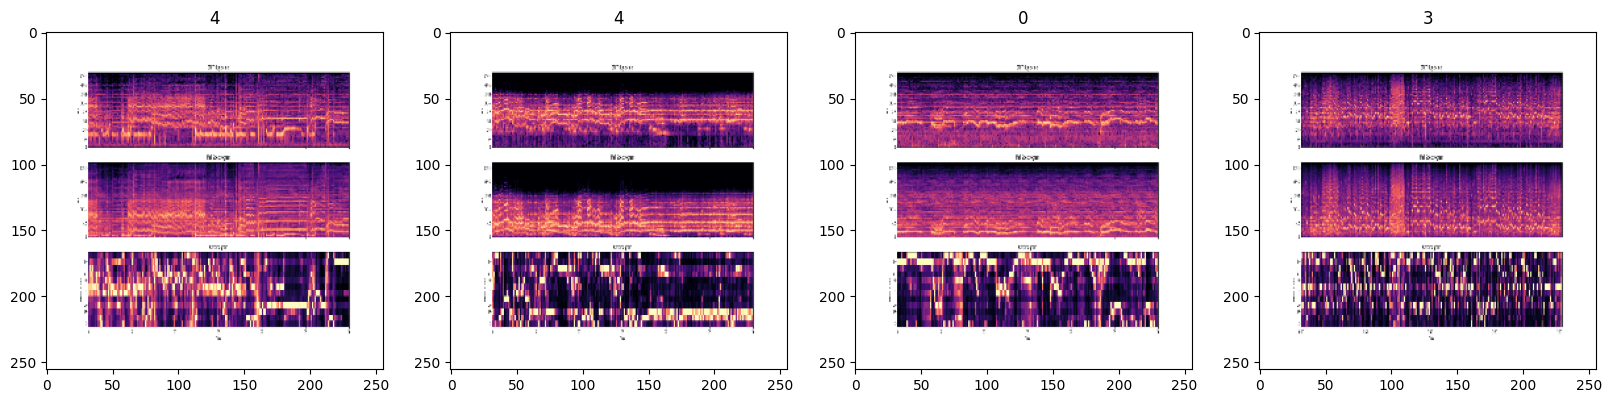

In [ ]:
#@title Creating Data Pipeline

import numpy as np

data = tf.keras.utils.image_dataset_from_directory('/content/drive/My Drive/Raga Identification/data', shuffle=True)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print("Batch 1 classes: ", batch[1], "\n")
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

datas = {}
data_iterators = {}
batches = {}
for i in os.listdir(data_dir[0]):
    datas[i] = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir[0], i), shuffle=True)
    data_iterators[i] = datas[i].as_numpy_iterator()
    batches[i] = data_iterators[i].next()
    print("Batch classes for ", i, " : ", batches[i][1], "\n")
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx, img in enumerate(batches[i][0][:4]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(batches[i][1][idx])

In [ ]:
#@title Preprocessing Data

''' Scaling Data '''
# Scaling Data
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].max()

for i in os.listdir(data_dir[0]):
    datas[i] = datas[i].map(lambda x,y: (x/255, y))
    print("For "+i+": ", datas[i].as_numpy_iterator().next()[0].max())
    break


''' Splitting Data '''
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)+1
test_size = int(len(data)*.1)+1

train = data.take(train_size)
val = data.take(val_size)
test = data.take(test_size)

trains = {}
tests = {}
vals = {}
for i in os.listdir(data_dir[0]):
    train_size = int(len(datas[i])*.8)
    val_size = int(len(datas[i])*.1)+1
    test_size = int(len(datas[i])*.1)+1
    print("For "+i+" : ", train_size, " + ", val_size, " + ", test_size, " = ", len(datas[i]))

    trains[i] = datas[i].take(train_size)
    vals[i] = datas[i].take(val_size)
    tests[i] = datas[i].take(test_size)
    break

In [ ]:
#@title Assigning weights to classes
from sklearn.utils.class_weight import compute_class_weight

labels = []
for batch in train.as_numpy_iterator():
    X1, y1 = batch
    labels.extend(list(y1))

labels = np.array(labels)
print(labels)

# Calculate class weights for thaat classes
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
class_weights = dict(zip(np.unique(labels), class_weights))


class_weights_r = {}
for i in os.listdir(data_dir[0]):
    labels = []
    for batch in trains[i].as_numpy_iterator():
        X1, y1 = batch
        labels.extend(list(y1))

    labels = np.array(labels)
    print("For", i, ":", labels)

    # Calculate class weights for thaat classes
    class_weights_r[i] = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
    class_weights_r[i] = dict(zip(np.unique(labels), class_weights_r[i]))

# **Deep Learning Models Creation, Training, Evaluating, Saving, Performance Graph etc.**

In [ ]:
#@title Deep Models CRNN2D, DenseNet

''' Deep Model '''
# The Network
import keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Concatenate, GlobalAveragePooling2D, BatchNormalization, ReLU, Add, SeparableConv2D, DepthwiseConv2D, GRU, LSTM, Permute, Reshape, Activation
from tensorflow.keras.applications import DenseNet201


def CRNN2D(X_shape, nb_classes):

    nb_layers = 4
    nb_filters = [64, 128, 128, 128]
    kernel_size = (3, 3)
    activation = 'elu'
    pool_size = [(2, 2), (4, 2), (4, 2), (4, 2),
                 (4, 2)]

    input_shape = (X_shape[0], X_shape[1], X_shape[2])
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    model = Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))

    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(MaxPool2D(pool_size=pool_size[0], strides=pool_size[0]))
    model.add(Dropout(0.1))

    for layer in range(nb_layers - 1):
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))
        model.add(MaxPool2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))
        model.add(Dropout(0.1))


    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model


def densenet(img_shape, n_classes):
    densenet = DenseNet201(input_shape=img_shape, include_top=False, weights='imagenet')
    densenet.trainable = False

    input = Input(img_shape)
    x = densenet(input, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate = 0.2)(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model



input_shape = (256, 256, 3)
n_classes = len(os.listdir(data_dir[0]))

model = CRNN2D(input_shape, n_classes)
model.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

models = {}
for i in os.listdir(data_dir[0]):
    n_classes = len(os.listdir(os.path.join(data_dir[0], i)))
    models[i] = densenet(input_shape, n_classes)
    models[i].compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    models[i].summary()
    break

In [ ]:
#@title Training the Models

# Train
logdir='/content/drive/My Drive/Raga Identification/logs'
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0010, patience=5, verbose=1, mode='max', restore_best_weights=True, start_from_epoch=5)
hist = model.fit(train, class_weight=class_weights, epochs=60, validation_data=val, callbacks=[tensorboard_callback1, tensorboard_callback2])
print(hist.history)

hists = {}
for i in os.listdir(data_dir[0]):
    print("\n\n For "+i)
    tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    tensorboard_callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0010, patience=5, verbose=1, mode='max', restore_best_weights=True, start_from_epoch=5)
    hists[i] = models[i].fit(trains[i], class_weight = class_weights_r[i], epochs=60, validation_data=vals[i], callbacks=[tensorboard_callback1, tensorboard_callback2])
    print(hists[i].history)
    break

In [ ]:
#@title Evaluating the Model

''' Evaluation '''
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import *

print("For Model CRNN2D: ")
loss, results = model.evaluate(test, batch_size=328, callbacks=[tensorboard_callback1, tensorboard_callback2])
print("Result : \n", results)
print("Loss: \n", loss)

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
pre1 = Precision()
re1 = Recall()
acc1 = BinaryAccuracy()
labels = []
predicts = []
for batch in test.as_numpy_iterator():
    X, y = batch
    labels.extend(list(y))
    yhat = model.predict(X, verbose=0)
    max = a = 0
    arr = np.ones(yhat.shape[0])*-1
    for i in yhat:
        max = np.argmax(i)
        arr[a] = max
        a+=1
    predicts.extend(list(arr))
    pre1.update_state(y, arr)
    re1.update_state(y, arr)
    acc1.update_state(y, arr)
print(f'Precision:{pre1.result().numpy()}, Recall:{re1.result().numpy()}, Accuracy:{acc1.result().numpy()}')
matrix = confusion_matrix(y, arr)
print("Confusion Matrix for DenseNet201: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = os.listdir(data_dir[0]))
display.plot()
plt.show()

print("For Test Dataset: ")
pre.update_state(labels, predicts)
re.update_state(labels, predicts)
acc.update_state(labels, predicts)
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy (Binary):{acc.result().numpy()}')
matrix = confusion_matrix(labels, predicts)
print("Confusion Matrix for Model on Test Dataset: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = os.listdir(data_dir[0]))
display.plot()
plt.show()



''' For the Ragas '''
losses = {}
results = {}
skip = 9
for i in os.listdir(data_dir[0]):
    losses[i], results[i] = models[i].evaluate(tests[i], batch_size=328, callbacks=[tensorboard_callback1, tensorboard_callback2])
    print("For ", i, " Result : ", results[i], " Loss : ", losses[i])

for i in os.listdir(data_dir[0]):
    print("\n\n For "+i)
    pre = Precision()
    re = Recall()
    acc = BinaryAccuracy()
    pre1 = Precision()
    re1 = Recall()
    acc1 = BinaryAccuracy()
    labels = []
    predicts = []
    for batch in tests[i].as_numpy_iterator():
        X, y = batch
        labels.extend(list(y))
        yhat = models[i].predict(X)
        max = a = 0
        arr = np.ones(yhat.shape[0])*-1
        for i in yhat:
            max = np.argmax(i)
            arr[a] = max
            a+=1
        predicts.extend(list(arr))
        pre1.update_state(y, arr)
        re1.update_state(y, arr)
        acc1.update_state(y, arr)
    print(f'Precission:{pre1.result().numpy()}, Recall:{re1.result().numpy()}, Accuracy:{acc1.result().numpy()}')
    matrix = confusion_matrix(y, arr)
    print("Confusion Matrix for ", i, ": \n", matrix)
    display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = os.listdir(data_dir[0]+"/"+i))
    display.plot()
    plt.show()

    print("For Test Dataset: ")
    pre.update_state(labels, predicts)
    re.update_state(labels, predicts)
    acc.update_state(labels, predicts)
    print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy (Binary):{acc.result().numpy()}')
    matrix = confusion_matrix(labels, predicts)
    print("Confusion Matrix for Model on Test Dataset: \n", matrix)
    display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = os.listdir(data_dir[0]))
    display.plot()
    plt.show()

In [ ]:
#@title Saving the Models and their Histories

# Saving Model

model.save(os.path.join('/content/drive/My Drive/Raga Identification/models','crnn2d_thaatclassifier.h5'))

for i in os.listdir(data_dir[0]):
    filename = i+".h5"
    models[i].save(os.path.join('/content/drive/My Drive/Raga Identification/models',filename))
    break

In [ ]:
#@title Re-Loading the Models and their Histories

from tensorflow.keras.models import load_model

# Loading the Models

model = load_model('/content/drive/My Drive/Raga Identification/models/crnn2d_thaatclassifier.h5')

for i in os.listdir(data_dir[0]):
    filename = i+".h5"
    models[i] = load_model('/content/drive/My Drive/Raga Identification/models/'+filename)
    break

In [ ]:
#@title Performance Graphs


import matplotlib.pyplot as plt

''' Model 1 '''
# Loss
fig = plt.figure()
plt.title("Model 1: Thaat Classifier\n\n", loc='center', fontsize=26)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


''' Rest of the models '''
a = 1
for i in os.listdir(data_dir[0]):
    title = "Model "+str(a)+": "+i+"\n"
    # Loss
    fig = plt.figure()
    plt.title(title, loc='center', fontsize=26)
    plt.plot(hists[i].history['loss'], color='teal', label='loss')
    plt.plot(hists[i].history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    # Accuracy
    fig = plt.figure()
    plt.plot(hists[i].history['accuracy'], color='teal', label='accuracy')
    plt.plot(hists[i].history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    a+=1

# **Evaluating and Testing the Models**

In [ ]:
#@title ROC-AUC Curves

import pandas as pd
import numpy as np
from sklearn.metrics import *
import math, os
from sklearn.preprocessing import label_binarize

#ROC-AUC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
def plot_roc(val_label,decision_val, caption='ROC Curve'):
    num_classes=np.unique(val_label).shape[0]
    classes = []
    for i in range(num_classes):
        classes.append(i)
    plt.figure()
    decision_val = label_binarize(decision_val, classes=classes)

    if num_classes!=2:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_val = label_binarize(val_label, classes=classes)
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(i+1, roc_auc[i]))
    else:
        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)
        roc_auc = auc(fpr,tpr)*100
        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right",  bbox_to_anchor=(1, 0.5))
    plt.savefig(str(len(classes))+'.png',dpi=300)

def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

def metrics(labels, predictions, classes, l):
    print("Classification Report:")
    print("Labels : ",labels.shape, '\nPredictions : ', predictions.shape)
    print(classification_report(labels, predictions, target_names = classes, digits = 4))
    matrix = confusion_matrix(labels, predictions)
    print("Confusion matrix:")
    print(matrix)
    display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = l)
    display.plot()
    plt.show()
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))
    print("\nBalanced Accuracy Score: ",balanced_accuracy_score(labels,predictions))

In [ ]:
#@title Testing the Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("For Model CRNN2D: ")
labels = []
predictions = []
for batch1 in test.as_numpy_iterator():
    X1, y1 = batch1
    labels.extend(list(y1))
    yhat1 = model.predict(X1, verbose=0)
    max = a = 0
    arr = np.ones(yhat1.shape[0])*-1
    for i in yhat1:
        max = np.argmax(i)
        arr[a] = max
        a+=1
    predictions.extend(list(arr))

labels = np.asarray(labels)
predictions = np.asarray(predictions)


metrics(labels, predictions, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plot_roc(labels, predictions)


avg_acc_list = []
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []

acc_fold = accuracy_score(labels, predictions)
avg_acc_list.append(acc_fold)
precision_fold = precision_score(labels, predictions, average='macro')
avg_precision_list.append(precision_fold)
recall_fold = recall_score(labels, predictions, average='macro')
avg_recall_list.append(recall_fold)
f1_fold  = f1_score(labels, predictions, average='macro')
avg_f1_list.append(f1_fold)

print('Accuracy[{:.4f}] Precision[{:.4f}] Recall[{:.4f}] F1[{:.4f}] ]'.format(acc_fold, precision_fold, recall_fold, f1_fold ))
print('________________________________________________________________')

avg_acc = np.asarray(avg_acc_list)
avg_pre = np.asarray(avg_precision_list)
avg_recall = np.asarray(avg_recall_list)
avg_f1 = np.asarray(avg_f1_list)
print("\n")
print('Overall Accuracy[{:.4f}] Overall Precision[{:.4f}] Overall Recall[{:.4f}] Overall F1[{:.4f}]'.format(np.mean(avg_acc), np.mean(avg_pre), np.mean(avg_recall), np.mean(avg_f1)))


''' For Ragas '''
for i in os.listdir(data_dir[0]):
    print("For "+i+": ")
    labels = []
    predictions = []
    for batch1 in tests[i].as_numpy_iterator():
        X1, y1 = batch1
        labels.extend(list(y1))
        yhat1 = models[i].predict(X1, verbose=0)
        max = a = 0
        arr = np.ones(yhat1.shape[0])*-1
        for i in yhat1:
            max = np.argmax(i)
            arr[a] = max
            a+=1
        predictions.extend(list(arr))

    labels = np.asarray(labels)
    predictions = np.asarray(predictions)

    classes = [z for z, p in enumerate(os.listdir(os.path.join(data_dir[0], i)))]
    classes = np.array(classes)
    classes+=1

    metrics(labels, predictions, classes)

    plot_roc(labels, predictions)


    avg_acc_list = []
    avg_precision_list = []
    avg_recall_list = []
    avg_f1_list = []

    acc_fold = accuracy_score(labels, predictions)
    avg_acc_list.append(acc_fold)
    precision_fold = precision_score(labels, predictions, average='macro')
    avg_precision_list.append(precision_fold)
    recall_fold = recall_score(labels, predictions, average='macro')
    avg_recall_list.append(recall_fold)
    f1_fold  = f1_score(labels, predictions, average='macro')
    avg_f1_list.append(f1_fold)

    print('Accuracy[{:.4f}] Precision[{:.4f}] Recall[{:.4f}] F1[{:.4f}] ]'.format(acc_fold, precision_fold, recall_fold, f1_fold ))
    print('________________________________________________________________')

    avg_acc = np.asarray(avg_acc_list)
    avg_pre = np.asarray(avg_precision_list)
    avg_recall = np.asarray(avg_recall_list)
    avg_f1 = np.asarray(avg_f1_list)
    print("\n")
    print('Overall Accuracy[{:.4f}] Overall Precision[{:.4f}] Overall Recall[{:.4f}] Overall F1[{:.4f}]'.format(np.mean(avg_acc), np.mean(avg_pre), np.mean(avg_recall), np.mean(avg_f1)))